# Анализ показателей интернет-сайта

In [317]:
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy import stats
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import numpy as np
import requests
from urllib.parse import urlencode
from io import StringIO
from statsmodels.stats.proportion import proportions_ztest

##1. A/B–тестирование

Составление словаря с названиями csv-файлов, используемых в проекте, и ссылками на них.

**groups** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)<br>
**active_studs** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.<br>
**checks** - файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [318]:
url = {"groups":"https://disk.yandex.ru/d/UhyYx41rTt3clQ",\
       "active_studs":"https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ",\
      "checks":"https://disk.yandex.ru/d/pH1q-VqcxXjsVA"}

Написание функции для загрузки данных.

In [319]:
def loading_data (url):
    start_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'    
    for key in url.keys():        
        df_name = key
        full_url = start_url + urlencode({'public_key': url[key]})
        response = requests.get(full_url)
        load_url = response.json()['href']
        df_name = key        
        try:                          
            if pd.read_csv(load_url, sep=',', nrows=1).shape[1] > 1:                
                globals()[df_name] = pd.read_csv(load_url, sep = ',')
                print(f"Создан DataFrame {key}") 
            elif pd.read_csv(load_url, sep=';', nrows=1).shape[1] > 1:
                globals()[df_name] = pd.read_csv(load_url, sep = ';')
                print(f"Создан DataFrame {key}")
            else:
                globals()[df_name] = pd.read_csv(load_url)
                print(f"Создан DataFrame {key}")
        except Exception as e:
            print(f"Ошибка при загрузке {key}: {e}")

Вызов функции загрузки данных

In [320]:
loading_data(url)

Создан DataFrame groups
Создан DataFrame active_studs
Создан DataFrame checks


Добавление новой колонки чтобы при дальнейшем объединении можно было определить активного клиента

In [321]:
active_studs['active'] = 1

Создание пустых df для изменения через функции.

In [322]:
full_df = pd.DataFrame()
metricks = pd.DataFrame()

Напишем функцию которая будет объединять данные.

In [323]:
def data_generation ():
    global full_df
        
    full_df = pd.merge(groups, checks, left_on='id', right_on='student_id', how='left')
    full_df = pd.merge(full_df, active_studs, left_on='id', right_on='student_id', how='left')
    del full_df['student_id_x']
    del full_df['student_id_y']

Запуск функции объединения данных.

In [324]:
data_generation ()

Напишем функцию которая будет расчитывать метрики на основе существующих файлов.

In [325]:
def сalculation_metrics ():
    global metricks
    # Расчет основных метрик
    metricks = full_df.groupby('grp',as_index = False).agg(revenue=('rev', 'sum'),user_count=('id', 'count'),active_user_count=('active', 'count'), paying_user = ('rev', 'count') )
    metricks['revenue'] = round(metricks['revenue'] ,2)    
    metricks = pd.merge(metricks, (full_df.query("rev != 'NaN' and active != 'NaN'").groupby('grp',as_index = False).agg(revenue_active = ('rev','sum'))), on='grp')  
    metricks['revenue_active'] = round(metricks['revenue_active'] ,2)
    metricks['active_user_pct'] = round(metricks['active_user_count'] *100/ metricks['user_count'],2)
    metricks['cr_to_paying'] = round(metricks['paying_user']*100/metricks['user_count'],2)    
    metricks['aov'] = round(metricks['revenue'] / metricks['paying_user'],2)
    metricks['arpu'] = round(metricks['revenue']/metricks['user_count'],2)
    metricks['arpau'] = round(metricks['revenue_active']/metricks['active_user_count'],2)
    
    return metricks

Проверка размера групп

In [326]:
full_df.groupby('grp',as_index = False)['id'].nunique()

,grp,id
0,A,14671
1,B,59813


**Вывод:** размер групп сильно отличается. Возможно есть проблема в системе сплитования.

Проверка количества платящих клиентов, не заходящих в приложение.

In [327]:
full_df.query("rev != 'NaN' and active == 'NaN'")['id'].count()

149

**Вывод**: у части клиентов (149 чел) прошла оплата без захода в приложение. Возможно произошла ошибка в системе оплаты либо у данных клиентов была оформлена подписка. Необходимы данные по клиентам с оформленной подпиской (если есть такая услуга). Вышеуказанные клиенты не будут учитываться для в дальнейшем исследовании. 

Исключение 149 клиентов из исследования.

In [328]:
full_df = full_df.query("(rev != 'NaN' and active == 'NaN') == False")

Запуск функции расчета метрик.

In [329]:
сalculation_metrics ()

,grp,revenue,user_count,active_user_count,paying_user,revenue_active,active_user_pct,cr_to_paying,aov,arpu,arpau
0,A,72820.0,14642,1535,78,72820.0,10.48,0.53,933.59,4.97,47.44
1,B,393074.0,59693,6793,313,393074.0,11.38,0.52,1255.83,6.58,57.86


**Вывод:**: гляда на выведенные метрики из таблицы metricks можно увидеть, что бальшая часть относительных показателей в группах существенно не отличаются. Показатель aov (средний размер оплаты) выделяется на их фоне и явно имеет различия между группами.<br>

Для дальнейшего исследования можно выделить следующие метрики, отражающие изменения в системе оплаты:<br>
- **AOV**<br>
- **CR** в платящего<br>
- **ARPAU**

### Анализ AOV

Подготовка групп

In [330]:
a = full_df.query("grp == 'A' and rev != 'Nan'")['rev'] 
b = full_df.query("grp == 'B' and rev != 'Nan'")['rev'] 

Проверка распределения на нормальность.

In [331]:
stats.normaltest(a)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

In [332]:
statistic, p_value = stats.shapiro(a)
print(p_value)

1.4986822893803264e-10


In [333]:
stats.normaltest(b)

NormaltestResult(statistic=7.022269699078301, pvalue=0.029863005181946005)

In [334]:
statistic, p_value = stats.shapiro(b)
print(p_value)

1.756778758085431e-16


**Вывод:** распределение ненормальное в обеих группах. Несмотря на ненормальность распределения, благодаря большому размеру выборки (n > 30), согласно центральной предельной теореме, распределение выборочных средних будет приближаться к нормальному, что позволяет использовать Т-тест.

Проверка равенства дисперсий при помощи теста Левене, который более устойчив к отклонениям от нормальности.

In [335]:
statistic, p_value = stats.levene(a, b)
print(p_value)

0.08123509393501775


**Вывод:** нет оснований отклонять нулевую гипотезу о равенстве дисперсий. Для дальнейшего анализа можно применить Т-тест Стьюдента.

Проведение Т-теста.

In [336]:
t_statistic, p_value = stats.ttest_ind(a, b)
print(p_value)

0.001999178025210522


**Вывод:** удалось получить стат значимое различие в размере среднего платежа между тестовой и контрольной группой. В тестовой группе AOV выше на 322 единицы.

### Анализ CR

Подготовка данных.

In [337]:
all_user = list(сalculation_metrics ()['user_count'])
paying_user = list(сalculation_metrics ()['paying_user'])

Проведение Т-теста.

In [338]:
z_stat, p_value = proportions_ztest(paying_user, all_user)
print(p_value)

0.9002155082697257


**Вывод:**  нет оснований отклонять нулевую гипотезу о равенстве конверсии в платящего у тестовой и контрольной группы.

### Анализ ARPAU

Подготовка групп

In [339]:
a_ARPAU = full_df.query("grp == 'A' and active == 1")['rev'].fillna(0)
b_ARPAU = full_df.query("grp == 'B' and active == 1")['rev'].fillna(0)

Проверка распределения на нормальность.

In [340]:
stats.normaltest(a_ARPAU)

NormaltestResult(statistic=2235.0038926868115, pvalue=0.0)

In [341]:
statistic, p_value = stats.shapiro(a_ARPAU)
print(p_value)

0.0


In [342]:
stats.normaltest(b_ARPAU)

NormaltestResult(statistic=7799.5839920248845, pvalue=0.0)

In [343]:
statistic, p_value = stats.shapiro(b_ARPAU)
print(p_value)

0.0


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Вывод:** распределение ненормальное в обеих группах. Несмотря на ненормальность распределения, благодаря большому размеру выборки (n > 30), согласно центральной предельной теореме, распределение выборочных средних будет приближаться к нормальному, что позволяет использовать Т-тест.

Проверка равенства дисперсий при помощи теста Левене, который более устойчив к отклонениям от нормальности.

In [344]:
statistic, p_value = stats.levene(a_ARPAU, b_ARPAU)
print(p_value)

0.2328800964343609


**Вывод:** Нет оснований отклонять нулевую гипотезу о равенстве дисперсий. Для дальнейшего анализа можно применить Т-тест Стьюдента.

Проведение Т-теста.

In [345]:
t_statistic, p_value = stats.ttest_ind(a_ARPAU, b_ARPAU)
print(p_value)

0.2328800964324922


**Вывод:** нет оснований отклонять нулевую гипотезу о равенстве средних значений у тестовой и контрольной группы.

**Итог:** 
1. Удалось доказать что, стат значимо увеличился средний платеж на платящего клиента. (AOV)<br>
2. Удалось доказать что, увеличение ARPAU в тестовой группе было не стат значимо.<br>
3. Удалось доказать что, уменьшение конверсии в платящего (cr_to_paying) не стат значимо. <br>

**Вывод:** так как средний платеж на платящего клиента стат значимо увеличился, а другие метрики стат значимо не ухудшались
можно резюмировать, что изменения положительно повлияли на тестовую группу (B) новую механику на всех пользователей.

## 2. Создание функций обновления данных и вузуализации
### 2.1 Обновление данных 
Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.<br>
**groups_add** - дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных.

In [251]:
def updating_clients ():
        # Определение уже существующего списка клиентов.  
        global groups
        old_df = groups
        # Подгрузка нового списка клиентов. 
        url = {"groups_add":"https://disk.yandex.ru/d/5Kxrz02m3IBUwQ"} 
        loading_data(url)        
        new_df = groups_add
        # Определение названий колонок в новом списке.
        for i in new_df:
            if 'B' in list(new_df[i]) or 'A' in list(new_df[i]): 
                new_group_column = i        
            else:
                new_id_column = i
        # Определение названий колонок в старом списке.
        for j in old_df:
            if 'B' in list(old_df[j]) or 'A' in list(old_df[j]): 
                old_group_column = j        
            else:
                old_id_column = j
        # Приведение названий колонок нового списка в соответствие со старым.
        df = new_df.rename(columns={new_group_column : old_group_column,new_id_column : old_id_column})
        # Объединенние списков и установка правильных индексов.
        df = pd.concat([old_df,df], axis=0).reset_index()        
        del df['index']
        # Проверка на дубликаты
        df = df.drop_duplicates() 
        # Внесение изменений в изначальный список.
        groups = df
        # Запуск сборки общего df с новыми данными.
        data_generation()
        # Выдача актуальных метрик
        return сalculation_metrics ()

In [215]:
updating_clients ()

Создан DataFrame groups_add


,grp,revenue,user_count,active_user_count,paying_user,revenue_active,active_user_pct,cr_to_paying,aov,arpu,arpau
0,A,92096.0,14693,1538,107,72820.0,10.47,0.73,860.71,6.27,47.35
1,B,481230.0,59883,6803,434,394974.0,11.36,0.72,1108.82,8.04,58.06


### 2.2 Визуализация данных
Реализовать функцию, которая будет строить графики по получаемым метрикам.

Функция для визуализации величин платежей.

In [298]:
def vis_aov():
    plt.figure(figsize=(10, 7)) # Увеличим размер графика для лучшей читаемости
    sns.boxplot(x="grp", y="rev", data=full_df.query("rev != 'Nan'")[['grp','rev']])
    plt.title("Сравнение платежей от клиентов")
    plt.ylabel("Значение платежа")
    plt.xlabel("Группа")
    plt.grid(True)
    plt.show()

Функция для визуализации доли активных клиентов.

In [314]:
def vis_cr():
    active_user = metricks[['grp','cr_to_paying']]
    labels = active_user['grp']
    android_users = [active_user['cr_to_paying'][0],active_user['cr_to_paying'][1]]
    colors = ['#FF8000', '#0000FF']
    width = 0.35       #Задаём ширину столбцов
    fig, ax = plt.subplots()
    ax.bar(labels, android_users, width, label='Неактивные',color=colors)
    
    ax.set_ylabel('Доля, в %')
    ax.set_title('CR в платящего')
    
    fig.set_size_inches(10, 7)
    plt.xlabel("Группа")
    plt.grid(True)
    plt.show()

In [315]:
def vis_arpau():
    active_user = metricks[['grp','arpau']]
    labels = active_user['grp']
    android_users = [active_user['arpau'][0],active_user['arpau'][1]]
    colors = ['#FF8000', '#0000FF']
    
    width = 0.35       #Задаём ширину столбцов
    fig, ax = plt.subplots()
    ax.bar(labels, android_users, width, label='Неактивные',color=colors)
    
    
    ax.set_title('ARPAU')
    
    fig.set_size_inches(10, 7)
    plt.xlabel("Группа")
    plt.grid(True)
    plt.show()

Функция, строящая графики по получаемым метрикам.

In [304]:
def visualisation ():
    vis_aov ()
    vis_cr ()
    vis_arpau ()

Запуск функции визуализации.

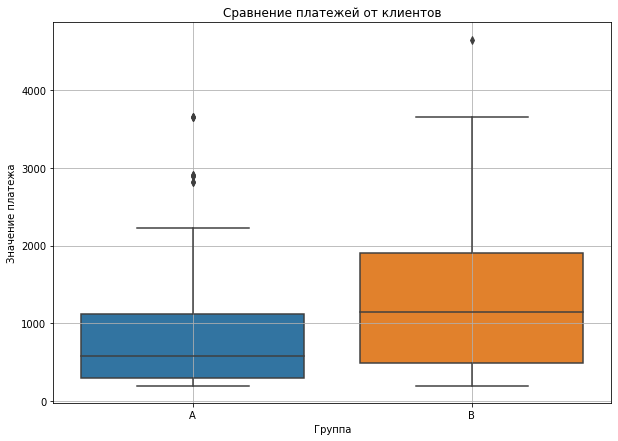

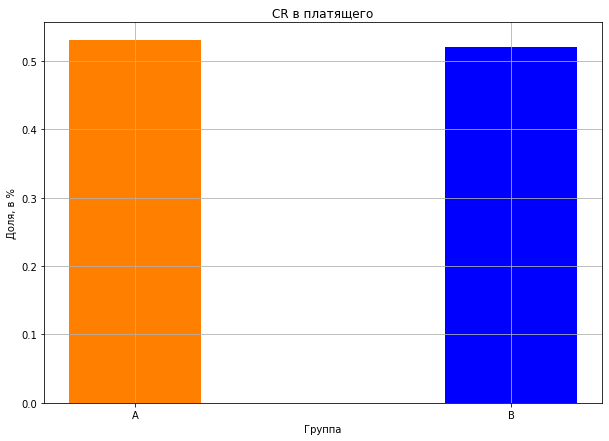

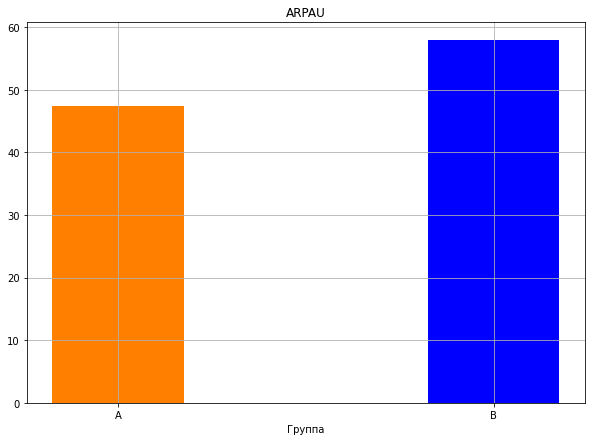

In [316]:
visualisation ()